In [118]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sn

In [53]:
df = pd.read_csv('/Users/noahcampana/Desktop/Studium/Master/Semester 1/Machine Learning/Project/project_data/train.csv', index_col = 'encounter_id')

In [54]:
df.shape  #71236 records

(71236, 30)

In [55]:
#df.dtypes

In [56]:
#df.isna().sum()

In [47]:
#df.describe(include="all").T

In [57]:
# I notice that there are some columns with the value '?', so I will replace all '?' and '' by Nan
# Ensure that missing data is uniformly represented in the dataset, whether it was initially recorded as '?' or an empty string.

# replace "" and "?" by nans
df.replace("", np.nan, inplace=True)
df.replace("?", np.nan, inplace=True)

In [58]:
#'change_in_meds_during_hospitalization' values: “change” (True) and “no change” (False)
#'prescribed_diabetes_meds' values: "yes" and "no"
#'readmitted_binary' values: "yes" (True) and "no" (False)

# converting it to a boolean will make it easier to work with as a binary indicator
# Booleans are a natural choice for binary indicators where you have only two possible values

df['readmitted_binary'] = df['readmitted_binary'].map({'Yes': True, 'No': False})
df['readmitted_binary'] = df['readmitted_binary'].astype(bool)

df['change_in_meds_during_hospitalization'] = df['change_in_meds_during_hospitalization'].map({'Ch': True, 'No': False})
df['change_in_meds_during_hospitalization'] = df['change_in_meds_during_hospitalization'].astype(bool)

df['prescribed_diabetes_meds'] = df['prescribed_diabetes_meds'].map({'Yes': True, 'No': False})
df['prescribed_diabetes_meds'] = df['prescribed_diabetes_meds'].astype(bool)


# preparing the target ('readmitted_multiclass') variable in a multiclass classification task
# assign to 'readmitted_multiclass' a unique integer value to each class, which is often more suitable for machine learning algorithms
class_mapping = {'No': 0, '<30 days': 1, '>30 days': 2}
df['readmitted_multiclass'] = df['readmitted_multiclass'].map(class_mapping)
df['readmitted_multiclass'] = df['readmitted_multiclass'].astype(int)

df.dtypes

country                                  object
patient_id                                int64
race                                     object
gender                                   object
age                                      object
weight                                   object
payer_code                               object
outpatient_visits_in_previous_year        int64
emergency_visits_in_previous_year         int64
inpatient_visits_in_previous_year         int64
admission_type                           object
medical_specialty                        object
average_pulse_bpm                         int64
discharge_disposition                    object
admission_source                         object
length_of_stay_in_hospital                int64
number_lab_tests                          int64
non_lab_procedures                        int64
number_of_medications                     int64
primary_diagnosis                        object
secondary_diagnosis                     

In [ ]:
# count of missing values
#df.isna().sum()

In [ ]:
#df.describe(include="all").T

# country
once column country only has only 1 value and it's completely fulfilled, it does not contribute to the analysis, so drop it


In [59]:
# once column country only has only 1 value and it's completely fulfilled, it does not contribute to the analysis, so drop it

df = df.drop(columns=['country'])


# gender
should we leave Unknown/Invalid ??? 
deviamos atribuir female ou male random?

In [60]:
df['gender'].value_counts() 

gender
Female             38228
Male               33005
Unknown/Invalid        3
Name: count, dtype: int64

# race

In [61]:
df['race'].value_counts()

race
Caucasian          50693
AfricanAmerican    12693
Hispanic            1364
Other                995
Asian                421
Name: count, dtype: int64

In [62]:
# missing values are relatively few compared to the total number of records.
# preserve the information that the race is missing, we can create a new category like "Unknown" (like gender)
# because the race is an important factor to the diabetes, according to some papers i've read
df['race'].fillna('Unknown', inplace=True)



# OTHER APPROACH------------------------
# Create a New Category: If you want to preserve the information that the race is missing,
# you can create a new category like "Unknown" or "Missing."
#df['race'].fillna('Caucasian', inplace=True)



# primary_diagnosis and secondary_diagnosis

the primary and secondary diagnosis are really important to predict the most suitable label, because
it represents what really took the patient to the hospital, so it's really important to keep the real values
and drop the missing ones instead of trying to 'figure out' what was the most probable digagnostic

once the missing values for the two attributes are very small, there's no problem on dropping them, so we can proceed with real values

In [63]:
df['primary_diagnosis'].value_counts()

primary_diagnosis
428       4776
414       4596
786       2846
410       2513
486       2488
          ... 
906          1
649          1
250.51       1
903          1
299          1
Name: count, Length: 686, dtype: int64

In [64]:
# The number of 'primary_diagnosis' missing values is relatively small and doesn't significantly impact the size 
# of the dataset, we can consider dropping the rows with missing values. In this case, with only 16 missing values 
# out of 71,236 records, this might be a reasonable approach if the missing values are randomly distributed.

df.dropna(subset=['primary_diagnosis'], inplace=True)


## secondary_diagnosis (dropei)

In [65]:
df.dropna(subset=['secondary_diagnosis'], inplace=True)  # maybe this depends a little on primary diagnonis 
# see below

In [66]:
# do not drop secondary when doing this

count_of_secondary_diagnoses = df.groupby('primary_diagnosis')['secondary_diagnosis'].count()
count_of_secondary_diagnoses.sort_values(ascending = False)

primary_diagnosis
428    4773
414    4594
786    2843
410    2513
486    2487
       ... 
381       1
878       1
875       1
870       1
10        1
Name: secondary_diagnosis, Length: 686, dtype: int64

# additional_diagnosis
Nao sei se dar encode em primary e secondary diretamente é bom
por causa de agrupar em sistemas (circulatorio, respiratorio, etc mais para a frente (portanto criei df_copy())

In [67]:
# additional_diagnosis

# Random Forest is a good choice for tabular data like the one you described. If your data has complex 
# relationships or non-linearity, Random Forest can capture those patterns.

# Since 'primary_diagnosis' and 'secondary_diagnosis' seem to be categorical variables, label encoding 
# would be a suitable approach

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Create a label encoder
label_encoder = LabelEncoder()

df_copy = df.copy()
# Apply label encoding to 'primary_diagnosis' and 'secondary_diagnosis'
df_copy['primary_diagnosis'] = label_encoder.fit_transform(df['primary_diagnosis'])
df_copy['secondary_diagnosis'] = label_encoder.fit_transform(df['secondary_diagnosis'])

# Now, 'primary_diagnosis' and 'secondary_diagnosis' have been encoded as numerical values

# Separate the dataset into parts with and without missing 'additional_diagnosis'
df_with_missing = df_copy[df_copy['additional_diagnosis'].isna()]
df_without_missing = df_copy[~df_copy['additional_diagnosis'].isna()]

# Define the features and target for the classification model
X = df_without_missing[['primary_diagnosis', 'secondary_diagnosis']]
y = (df_without_missing['additional_diagnosis'].notna()).astype(int)

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a classification model (e.g., RandomForest)
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Use the trained model to predict if 'additional_diagnosis' is present for the part with missing values
X_predict = df_with_missing[['primary_diagnosis', 'secondary_diagnosis']]
y_predict = clf.predict(X_predict)

# Update the missing 'additional_diagnosis' values based on predictions
df.loc[df['additional_diagnosis'].isna(), 'additional_diagnosis'] = y_predict

# Now, the missing 'additional_diagnosis' values have been imputed based on the classification model's predictions.


# weight  (nao dropar - explicaçao)

-> weight would be an important measure between the first and second visits, in order to check if there is any weight difference

-> selected_df' was created to assess the importance of the 'weight' attribute in capturing patient historical data during the first visit (when they are on their second hospital visit)

-> with 10,509 missing 'weight' values out of 10,566 records (approximately 99.5%) in 'selected_df,' it suggests that 'weight' may not be reliable for these visits.

-> the substantial number of missing values suggests that the 'weight' data may not be consistently recorded, or it may not be significantly informative for these visits. Imputing missing values could introduce noise and potentially mislead the analysis.

-> By doing so, we mitigate the impact of missing data and ensure the integrity of the analysis aligns with the dataset's primary research objectives.


In [68]:
# .create a df with the patients that went to the hospital 2 times or more, but only with the first 2 visits

patient_counts = df['patient_id'].value_counts()
patients_with_at_least_two_encounters = patient_counts[patient_counts >= 2].index

# Filter the DataFrame to include only patients with at least two encounters
selected_df = df[df['patient_id'].isin(patients_with_at_least_two_encounters)]

# Sort the selected DataFrame by 'patient_id' and 'encounter_id' in ascending order
selected_df = selected_df.sort_values(by=['patient_id', 'encounter_id'])

# Keep only the first two encounters for each patient
selected_df = selected_df.groupby('patient_id').head(2).reset_index(drop=True)
selected_df

,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
0,135,Caucasian,Female,[50-60),NaN,NaN,0,0,0,Urgent,...,997,560,8,NaN,NaN,True,True,"['metformin', 'glyburide', 'insulin']",True,1
1,135,Caucasian,Female,[50-60),NaN,NaN,0,0,1,Emergency,...,41,250,5,NaN,NaN,True,True,"['metformin', 'glyburide']",False,2
2,1152,AfricanAmerican,Female,[50-60),NaN,NaN,0,0,1,Emergency,...,250.01,1,2,NaN,NaN,False,True,['insulin'],False,2
3,1152,AfricanAmerican,Female,[60-70),NaN,NaN,0,0,2,Emergency,...,287,466,5,NaN,NaN,True,True,['insulin'],False,0
4,1314,Caucasian,Female,[40-50),NaN,NaN,0,0,2,Emergency,...,250,414,7,NaN,NaN,True,True,"['metformin', 'insulin']",False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21041,187920311,Unknown,Female,[60-70),NaN,PO,0,0,0,Emergency,...,599,816,9,NaN,NaN,True,True,"['glipizide', 'insulin']",True,1
21042,188284883,Other,Female,[80-90),NaN,MC,0,0,0,Emergency,...,211,562,5,NaN,NaN,True,True,"['glipizide', 'rosiglitazone', 'insulin']",False,2
21043,188284883,Other,Female,[80-90),NaN,MC,0,0,1,Emergency,...,285,250,8,NaN,NaN,True,True,"['glipizide', 'rosiglitazone', 'insulin']",False,0
21044,189257846,Asian,Male,[60-70),NaN,HM,0,0,0,Emergency,...,276,473,9,NaN,>8,False,True,['insulin'],False,2


In [69]:
# comparing the number of Nan values of 'weight' with the nr of records

print('Nr of weight missing values in selected_df:', selected_df['weight'].isna().sum())
print('Nr of records in selected_df:', selected_df.shape[0])
print('% of weight missing values in selected_df:', round((selected_df['weight'].isna().sum() / selected_df.shape[0]) * 100, 1), '%')

Nr of weight missing values in selected_df: 20732
Nr of records in selected_df: 21046
% of weight missing values in selected_df: 98.5 %


In [70]:
# nr of people from selected_df that have their weights registered from the first and second visits
count = (selected_df.groupby('patient_id')['weight'].apply(lambda x: x.isna().sum()) == 0).sum()
count

148

In [71]:
# get the people from selected_df with both weights

# Group by 'patient_id' and aggregate the weight values as a list for each patient
weight_lists = selected_df.groupby('patient_id')['weight'].apply(list)

# Filter for patients with different weight values between their first and second visits
patients_with_weight_difference = weight_lists[weight_lists.apply(lambda x: len(set(x)) > 1)]

# Create a DataFrame with only the records of patients with weight differences
result_df = selected_df[selected_df['patient_id'].isin(patients_with_weight_difference.index)]
nr_patients_different_weights = result_df.shape[0] / 2 # divide by 2 because there is the same patient twice
nr_patients_different_weights
## 44/151 = 0.29 -> 29% of people whose weights were recorded in the first and second visits had a weight difference

58.0

-> It's important to assess whether these weight differences are clinically significant. Even small changes in weight can have an impact on a person's health, particularly for individuals with diabetes, as it may affect their glycemic control.

-> For the 44 patients with weight differences, it may be valuable to review their medical records and assess whether these variations are expected or if they warrant further investigation or intervention.

-> Overall, the 29% difference highlights the importance of tracking changes in weight over time for individuals with diabetes. It could serve as a starting point for further investigation and potential interventions to improve patient care and glycemic control.

In [72]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

result_df

,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,medical_specialty,average_pulse_bpm,discharge_disposition,admission_source,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
1426,1743804,Unknown,Male,[30-40),NaN,MC,1,2,9,Emergency,InternalMedicine,133,Left AMA,Emergency Room,1,41,0,6,250.11,403,276,9,NaN,NaN,False,False,[],True,1
1427,1743804,Caucasian,Male,[30-40),[50-75),MC,1,2,9,Emergency,InternalMedicine,62,Discharged to home,Emergency Room,3,38,2,15,530,250.11,250.41,9,NaN,NaN,False,True,['insulin'],True,1
2098,3356505,Caucasian,Female,[40-50),[125-150),DM,1,0,1,Urgent,NaN,118,Discharged to home,Physician Referral,5,29,0,13,296,303,493,8,NaN,Norm,False,True,['metformin'],False,0
2099,3356505,Caucasian,Female,[40-50),[100-125),DM,1,0,0,Emergency,NaN,124,Discharged to home,Emergency Room,3,65,0,13,296,V62,296,9,NaN,NaN,False,True,['metformin'],False,2
2196,3515238,Caucasian,Female,[40-50),[100-125),NaN,4,0,1,Emergency,Psychiatry,129,Discharged/transferred to another short term h...,Emergency Room,4,60,0,12,296,599,584,9,NaN,NaN,True,True,"['metformin', 'glipizide', 'insulin']",True,1
2197,3515238,Caucasian,Female,[50-60),NaN,CM,4,1,0,Emergency,Family/GeneralPractice,110,Discharged to home,Emergency Room,4,68,0,11,280,584,626,8,NaN,>7,True,True,['insulin'],False,2
2392,4019499,Caucasian,Female,[80-90),NaN,MC,0,0,0,Emergency,InternalMedicine,110,Discharged/transferred to SNF,Transfer from a Skilled Nursing Facility (SNF),3,51,0,24,486,403,250.6,9,NaN,NaN,True,True,"['glipizide', 'insulin']",True,1
2393,4019499,Caucasian,Female,[80-90),[50-75),NaN,0,0,0,Urgent,Surgery-General,80,Discharged/transferred to SNF,Physician Referral,9,72,1,26,250.8,730,731,9,NaN,NaN,True,True,"['glipizide', 'insulin']",False,2
3298,7994817,Unknown,Female,[40-50),[75-100),NaN,0,0,1,NaN,InternalMedicine,93,Discharged to home,NaN,8,38,2,22,682,824,E928,7,NaN,Norm,False,True,['insulin'],False,2
3299,7994817,Caucasian,Female,[40-50),NaN,NaN,0,1,0,Emergency,InternalMedicine,95,Discharged to home,Emergency Room,2,56,0,13,276,250.11,V42,9,NaN,NaN,True,True,['insulin'],False,2


In [73]:
# all the patients that were readmitted (shows the first and second visits)
a = result_df[result_df['readmitted_binary'] == True]['patient_id']
filtered_result_df = result_df[result_df['patient_id'].isin(a)]
filtered_result_df

,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,medical_specialty,average_pulse_bpm,discharge_disposition,admission_source,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
1426,1743804,Unknown,Male,[30-40),NaN,MC,1,2,9,Emergency,InternalMedicine,133,Left AMA,Emergency Room,1,41,0,6,250.11,403,276,9,NaN,NaN,False,False,[],True,1
1427,1743804,Caucasian,Male,[30-40),[50-75),MC,1,2,9,Emergency,InternalMedicine,62,Discharged to home,Emergency Room,3,38,2,15,530,250.11,250.41,9,NaN,NaN,False,True,['insulin'],True,1
2196,3515238,Caucasian,Female,[40-50),[100-125),NaN,4,0,1,Emergency,Psychiatry,129,Discharged/transferred to another short term h...,Emergency Room,4,60,0,12,296,599,584,9,NaN,NaN,True,True,"['metformin', 'glipizide', 'insulin']",True,1
2197,3515238,Caucasian,Female,[50-60),NaN,CM,4,1,0,Emergency,Family/GeneralPractice,110,Discharged to home,Emergency Room,4,68,0,11,280,584,626,8,NaN,>7,True,True,['insulin'],False,2
2392,4019499,Caucasian,Female,[80-90),NaN,MC,0,0,0,Emergency,InternalMedicine,110,Discharged/transferred to SNF,Transfer from a Skilled Nursing Facility (SNF),3,51,0,24,486,403,250.6,9,NaN,NaN,True,True,"['glipizide', 'insulin']",True,1
2393,4019499,Caucasian,Female,[80-90),[50-75),NaN,0,0,0,Urgent,Surgery-General,80,Discharged/transferred to SNF,Physician Referral,9,72,1,26,250.8,730,731,9,NaN,NaN,True,True,"['glipizide', 'insulin']",False,2
7178,27120762,Caucasian,Female,[70-80),[0-25),CM,13,1,1,Elective,Cardiology,134,Discharged to home,Physician Referral,3,69,6,17,410,414,599,9,NaN,NaN,False,True,['insulin'],True,1
7179,27120762,Caucasian,Female,[70-80),[50-75),CM,9,0,0,Emergency,NaN,68,Discharged to home,Emergency Room,3,61,0,15,433,585,584,9,NaN,NaN,False,True,['insulin'],False,2
11854,54253962,Caucasian,Female,[70-80),[75-100),NaN,0,0,2,NaN,Family/GeneralPractice,133,Discharged to home,Emergency Room,6,64,0,19,402,595,250,7,NaN,NaN,True,True,"['metformin', 'rosiglitazone']",False,0
11855,54253962,Caucasian,Female,[70-80),NaN,NaN,0,0,0,NaN,Family/GeneralPractice,126,Discharged to home,Emergency Room,6,67,0,16,436,438,729,7,NaN,NaN,True,True,"['metformin', 'glimepiride', 'rosiglitazone']",True,1


# dropar weight  (o que faz mais sentido)

Dropped the 'weight' column because it had a very high percentage of missing values, approximately 97%. With such a large number of missing values, imputing or filling them could lead to misleading or inaccurate results. Additionally, since 'weight' might not be a critical feature for your analysis or predictions, removing the column was a reasonable choice to reduce complexity and potential issues caused by the missing data.


In [74]:
df = df.drop(columns=['weight'])

# age

In [75]:
df['age'].value_counts()


age
[70-80)     17330
[60-70)     14875
[80-90)     11485
[50-60)     11404
[40-50)      6393
[30-40)      2522
[90-100)     1873
[20-30)      1047
[10-20)       405
[0-10)         75
Name: count, dtype: int64

In [76]:
# Identify rows with missing 'age' values
missing_age_rows = df[df['age'].isna()]

# Filter rows of patients who visited more than once and have at least one non-missing 'age' value
potential_fill_rows = df[df['patient_id'].isin(missing_age_rows['patient_id']) & df['age'].notna()]

# Find the number of missing 'age' values that can potentially be filled
fillable_values = potential_fill_rows['patient_id'].nunique()

# Calculate the percentage of fillable missing 'age' values
percentage_fillable = (fillable_values / len(missing_age_rows)) * 100

fillable_values, percentage_fillable

(1293, 36.4225352112676)

In [77]:
#check if the code actually found what we were searching for with one patient_id
df[df['patient_id']==84369501]

,patient_id,race,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,medical_specialty,average_pulse_bpm,discharge_disposition,admission_source,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
926554,84369501,Caucasian,Female,[80-90),MC,5,0,3,Emergency,NaN,122,Discharged/transferred to home with home healt...,Physician Referral,3,71,0,20,428,427,599,9,NaN,NaN,True,True,"['rosiglitazone', 'insulin']",False,2
134334,84369501,Caucasian,Female,[80-90),MC,3,0,1,Emergency,NaN,113,Discharged/transferred to home with home healt...,Emergency Room,9,64,0,21,428,424,780,9,NaN,NaN,False,True,['rosiglitazone'],True,1
650603,84369501,Caucasian,Female,[80-90),MC,0,0,0,Urgent,Radiologist,102,Discharged/transferred to SNF,Physician Referral,14,3,3,14,276,427,428,9,NaN,NaN,False,True,['rosiglitazone'],False,2
922922,84369501,Caucasian,Female,[80-90),MC,4,0,2,Emergency,NaN,139,Discharged/transferred to SNF,Emergency Room,4,63,1,21,428,427,V43,9,NaN,NaN,False,True,['rosiglitazone'],False,2
144712,84369501,Caucasian,Female,NaN,MC,5,0,4,Emergency,NaN,66,Discharged/transferred to home with home healt...,Emergency Room,14,75,2,31,434,276,599,9,NaN,NaN,False,True,['rosiglitazone'],True,1
409471,84369501,Caucasian,Female,[80-90),MC,6,0,5,Emergency,NaN,88,Discharged/transferred to home with home healt...,Emergency Room,2,49,1,12,578,427,428,9,NaN,NaN,False,False,[],False,0


In [78]:
#now we are filling the missing values
age_dict = dict(zip(potential_fill_rows['patient_id'], potential_fill_rows['age']))
df['age'] = df.apply(
    lambda row: age_dict[row['patient_id']] if pd.isna(row['age']) and row['patient_id'] in age_dict else row['age'], axis=1)


In [79]:
#check if the code worked with the same patient 
df[df['patient_id']==84369501]

,patient_id,race,gender,age,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,admission_type,medical_specialty,average_pulse_bpm,discharge_disposition,admission_source,length_of_stay_in_hospital,number_lab_tests,non_lab_procedures,number_of_medications,primary_diagnosis,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
encounter_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
926554,84369501,Caucasian,Female,[80-90),MC,5,0,3,Emergency,NaN,122,Discharged/transferred to home with home healt...,Physician Referral,3,71,0,20,428,427,599,9,NaN,NaN,True,True,"['rosiglitazone', 'insulin']",False,2
134334,84369501,Caucasian,Female,[80-90),MC,3,0,1,Emergency,NaN,113,Discharged/transferred to home with home healt...,Emergency Room,9,64,0,21,428,424,780,9,NaN,NaN,False,True,['rosiglitazone'],True,1
650603,84369501,Caucasian,Female,[80-90),MC,0,0,0,Urgent,Radiologist,102,Discharged/transferred to SNF,Physician Referral,14,3,3,14,276,427,428,9,NaN,NaN,False,True,['rosiglitazone'],False,2
922922,84369501,Caucasian,Female,[80-90),MC,4,0,2,Emergency,NaN,139,Discharged/transferred to SNF,Emergency Room,4,63,1,21,428,427,V43,9,NaN,NaN,False,True,['rosiglitazone'],False,2
144712,84369501,Caucasian,Female,[80-90),MC,5,0,4,Emergency,NaN,66,Discharged/transferred to home with home healt...,Emergency Room,14,75,2,31,434,276,599,9,NaN,NaN,False,True,['rosiglitazone'],True,1
409471,84369501,Caucasian,Female,[80-90),MC,6,0,5,Emergency,NaN,88,Discharged/transferred to home with home healt...,Emergency Room,2,49,1,12,578,427,428,9,NaN,NaN,False,False,[],False,0


In [80]:
# once age is important, replace age missing values by 'Unknown'
#df['age'].fillna('Unknown', inplace=True)

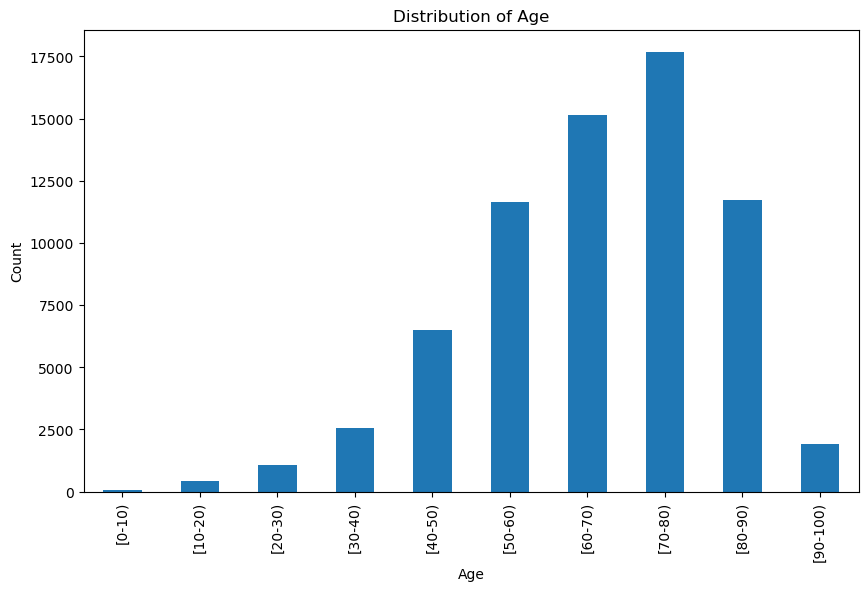

In [81]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named 'df'
# Replace 'df' with your actual DataFrame

# Group the data by the 'age' column and count the occurrences
age_counts = df['age'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
age_counts.plot(kind='bar')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


# admission_source

In [82]:
df['admission_source'].value_counts()

admission_source
 Emergency Room                                               40183
 Physician Referral                                           20596
Transfer from a hospital                                       2219
 Transfer from another health care facility                    1526
Clinic Referral                                                 779
 Transfer from a Skilled Nursing Facility (SNF)                 594
HMO Referral                                                    129
 Not Mapped                                                     107
 Not Available                                                   86
 Court/Law Enforcement                                           11
 Transfer from hospital inpt/same fac reslt in a sep claim        8
 Transfer from critial access hospital                            7
 Transfer from Ambulatory Surgery Center                          2
 Extramural Birth                                                 1
Normal Delivery                

In [83]:
# once 'Emergency Room' is the most common admission source, we replace the missing values by that 

mode_admission_source = df['admission_source'].mode()[0]
df['admission_source'].fillna(mode_admission_source, inplace=True)

# admission_type

In [84]:
df['admission_type'].value_counts()

admission_type
Emergency        37569
Elective         13175
Urgent           12971
Not Available     3318
Not Mapped         214
Trauma Center       13
Newborn              6
Name: count, dtype: int64

In [85]:
# ."admission_type" attribute may still have some relevance, although it might not be as directly related 
# to the target variable ("readmitted_binary") as some other attributes.
mode_admission_source = df['admission_type'].mode()[0]
df['admission_type'].fillna(mode_admission_source, inplace=True)


# payer_code
meter 'No' para susbstituir Nan

mais para a frente em feature engineering: alterar para True ou False para saber quem tem ou não


We have a hypothesis, that there are health insurances that cover more which leads patients to come back earlier and more often. First we wanted to do 1 extra column that just looks if a person is insured or not and one that differentiates between the different insurances. However we stayed with 1 column as we think we achieve the same perfomance

In [86]:
df['payer_code'].fillna('No', inplace=True)

In [87]:
#hospital['nan'] = hospital['payer_code'].apply(lambda x: False if x == '?' else True).astype(bool)
#turn it into 0 and 1 
#hospital['nan'] = hospital['nan'].astype(int)
#add another column
#hospital['insurance_status'] = np.where(hospital['nan'], hospital['payer_code'], 'Uninsured')

# medical_speaciality

talvez medical_Speciality esta relacionado com primary_diagnosis pq foi onde o paciente entrou primeiro por
lhe terem diagnosticado algo??

In [88]:
#df['medical_specialty'].value_counts()

In [89]:
# impute the missing values with the most frequent category (mode) since this 
# strategy is often used for categorical data

mode_specialty = df['medical_specialty'].mode()[0]
df['medical_specialty'].fillna(mode_specialty, inplace=True)

In [90]:
mode_specialty = df['medical_specialty'].mode()[0]
mode_specialty

'InternalMedicine'

In [91]:
df.isna().sum()

patient_id                                   0
race                                         0
gender                                       0
age                                       2211
payer_code                                   0
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                               0
medical_specialty                            0
average_pulse_bpm                            0
discharge_disposition                     2585
admission_source                             0
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                            0
secondary_diagnosis                          0
additional_diagnosis                         0
number_diagnoses                             0
glucose_test_

# discharge_disposition
Readmission Risk: Some discharge dispositions, such as discharging to a rehabilitation facility or skilled nursing home, may be associated with a higher risk of readmission. Understanding these patterns can help in predicting and preventing readmissions within 30 days.

In [92]:
#df['discharge_disposition'].value_counts()

In [93]:
mode_discharge = df['discharge_disposition'].mode()[0]
df['discharge_disposition'].fillna(mode_discharge, inplace=True)

# glucose_test_result
use "none" to indicate the test was not taken, replacing nan (mas não ha nenhum valor com nan originalmente, asumir que vazio/nan é none??)

-> 67548 missing values out of 71236 (94.8%)

-> glucose tests are critically important for individuals with diabetes. These tests play a significant role in managing diabetes and ensuring the overall health and well-being of people with the condition.

-> Glycemic Control: Glucose tests help assess how well a person with diabetes is managing their blood sugar levels. Monitoring blood sugar levels is essential for maintaining glycemic control within a target range, which is critical in preventing complications associated with diabetes.

In [94]:
df['glucose_test_result'].value_counts()

glucose_test_result
Norm    1805
>200    1055
>300     825
Name: count, dtype: int64

In [95]:
df['glucose_test_result'].fillna('None', inplace=True)

# a1c_test_result
information about your average levels of blood glucose, also called blood sugar, over the past 3 months. 
se calhar nao foi feito o teste qaundo o valor é nan pois nao existem none, tal como acontece em glucose_test_result

Why should a person get the A1C test?

Testing can help health care professionals

    -> find prediabetes and counsel you about lifestyle changes to help you delay or prevent type 2 diabetes
    -> find type 2 diabetes
    -> work with you to monitor the disease and help make treatment decisions to prevent complications


In [96]:
df['a1c_test_result'].value_counts()

a1c_test_result
>8      5609
Norm    3496
>7      2700
Name: count, dtype: int64

In [97]:
df['a1c_test_result'].fillna('None', inplace=True)

sem missing values
# ---------------------------------------------------------

# medication (atribuir um numero para cada grupo de mediamentos diferente)

In [98]:
df['medication'].value_counts()

medication
['insulin']                                                                                    21561
[]                                                                                             16304
['metformin']                                                                                   3142
['metformin', 'insulin']                                                                        3029
['glipizide']                                                                                   2724
['glyburide']                                                                                   2392
['glipizide', 'insulin']                                                                        2343
['glyburide', 'insulin']                                                                        1531
['pioglitazone', 'insulin']                                                                     1214
['metformin', 'glyburide']                                                      

In [99]:
# criar colunas nao é bom pq sao 303
dummies = pd.get_dummies(df['medication'], prefix='medication')
dummies.shape

(70959, 303)

### Correlation Matrix

Seems like the highest correlation values we have are: <br>
<b>0.46</b>: length_of_stay_in_hospital - number_of_medication <br>
<b>0.39</b>: length_of_stay_in_hospital - non_lab_procedures <br>
<b>0.32</b>: length_of_stay_in_hospital - number_lab_test <br>
<b>0.27</b>: emergency_visits_in_previous_year - inpatient_visits_in_previous_year <br>
<b>0.27</b>: number_lab_tests - number_of_medications <br>
<b>0.26</b>: number_of_medications - number_diagnoses <br>
<b>0.22</b>: number_diagnoses - length_of_stay_in_hospital

In [120]:
df.columns

Index(['patient_id', 'race', 'gender', 'age', 'payer_code',
       'outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'admission_type',
       'medical_specialty', 'average_pulse_bpm', 'discharge_disposition',
       'admission_source', 'length_of_stay_in_hospital', 'number_lab_tests',
       'non_lab_procedures', 'number_of_medications', 'primary_diagnosis',
       'secondary_diagnosis', 'additional_diagnosis', 'number_diagnoses',
       'glucose_test_result', 'a1c_test_result',
       'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds',
       'medication', 'readmitted_binary', 'readmitted_multiclass'],
      dtype='object')

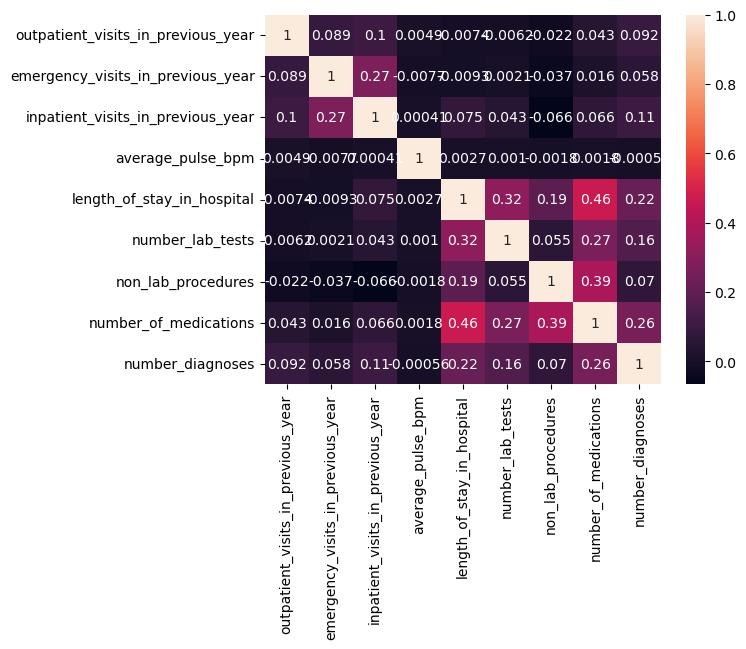

In [123]:
numeric_col = ["outpatient_visits_in_previous_year", "emergency_visits_in_previous_year", "inpatient_visits_in_previous_year", "average_pulse_bpm", "length_of_stay_in_hospital", "number_lab_tests", "non_lab_procedures", "number_of_medications", "number_diagnoses"]
correlation_matrix = df[numeric_col].corr()
sn.heatmap(correlation_matrix, annot=True)
plt.show()

### Outlier Removal

There are outliers for these columns that we can think about removing using the IQR method <br>
number_diagnoses, inpatient_visits_in_previous_year, length_of_stay_in_hospital, non_lab_procedures <br>
maybe also: number_lab_tests

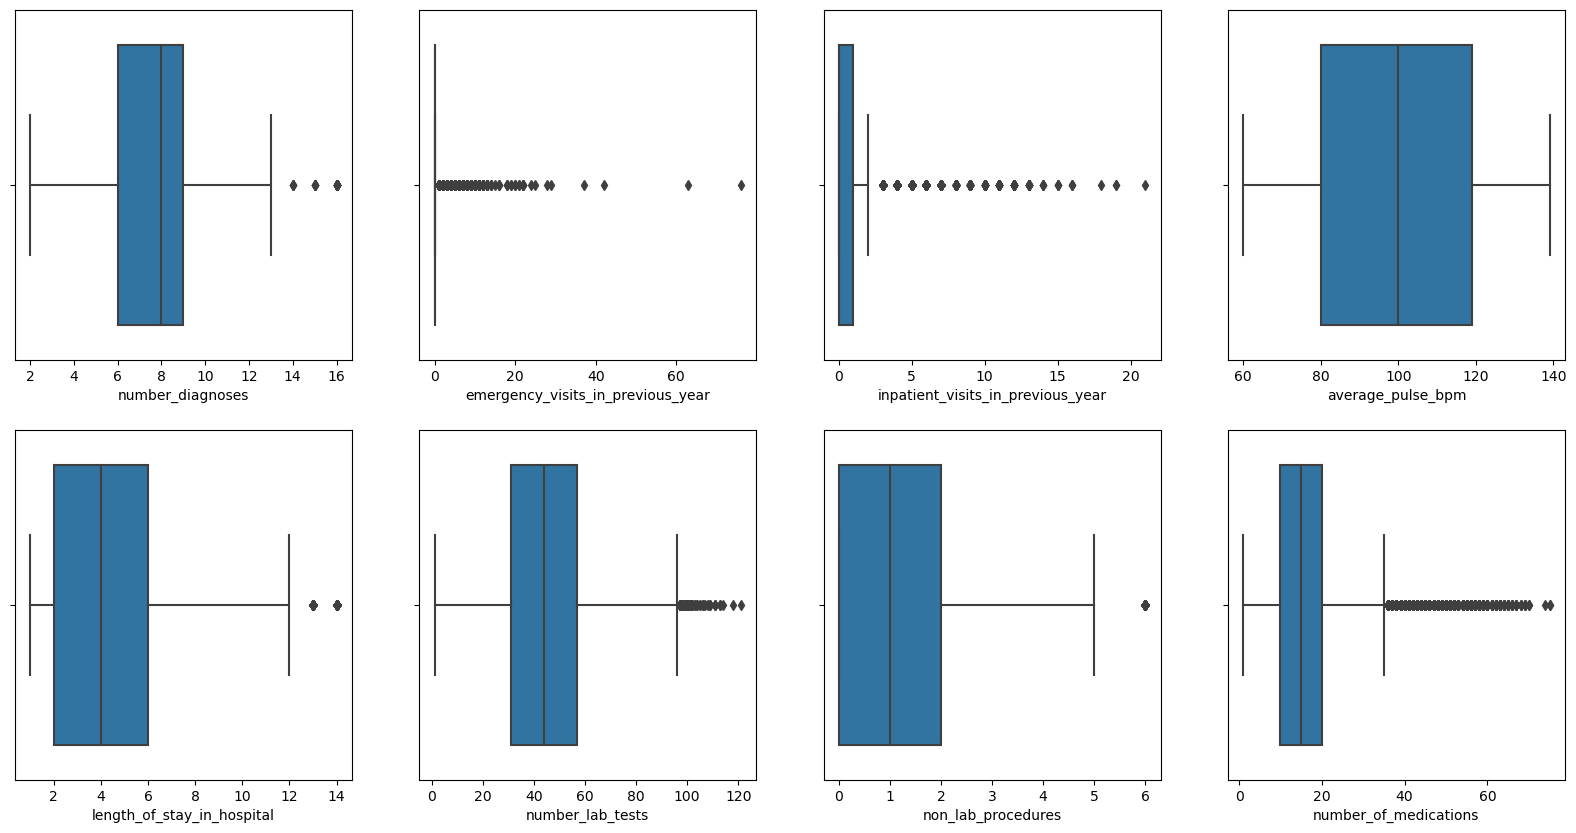

In [137]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Manually create box plots for each column
sn.boxplot(data=df, x='number_diagnoses', ax=axs[0, 0])
sn.boxplot(data=df, x='emergency_visits_in_previous_year', ax=axs[0, 1])
sn.boxplot(data=df, x='inpatient_visits_in_previous_year', ax=axs[0, 2])
sn.boxplot(data=df, x='average_pulse_bpm', ax=axs[0, 3])
sn.boxplot(data=df, x='length_of_stay_in_hospital', ax=axs[1, 0])
sn.boxplot(data=df, x='number_lab_tests', ax=axs[1, 1])
sn.boxplot(data=df, x='non_lab_procedures', ax=axs[1, 2])
sn.boxplot(data=df, x='number_of_medications', ax=axs[1, 3])

plt.show()
